# Kerr Angle Conversions Example Notebook

## Loading the package

First, load in the package using the following command

In [1]:
import os
import sys

# Need to point to where the package is installed
# It will always be in the build directory, but the next folder name might change on your machine
sys.path.append(os.path.abspath('../build/lib.macosx-11.0-arm64-cpython-39'))
import kerrangleconversions as kac

Load in the other packages we will need for this notebook

In [2]:
from time import perf_counter
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = r'\\usepackage{amsmath}' #for \text command



## Example Conversion

First, we assign the orbital elements of the geodesic orbit

In [3]:
a = 0.9
p = 7
e = 0.5
x = 0.5

Then we assign the values of the phases

In [4]:
psi0 = 1.2
chi0 = 0.5
phi0 = 5

We are going to convert from Quasi-Keplerian or Dawrin Phases to the Boyer-Lindquist action angles

In [5]:
time = perf_counter()
(Phi_r,Phi_theta,Phi_phi) = kac.pyDarwinPhasesToBoyerLindquistPhases(a,p,e,x,psi0,chi0,phi0)
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)
(Phi_r,Phi_theta,Phi_phi)

Time taken: 0.126 ms


(0.5911835154403845, -0.6547346825798834, 3.3156916526040807)

Now, we are going to take our solution and test the inverse transformation from Boyer-Lindquist actio angles back to Quasi-Keplerian phases

In [6]:
time = perf_counter()
(psi2,chi2,phi2) = kac.pyBoyerLindquistPhasesToDarwinPhases(a,p,e,x,Phi_r,Phi_theta,Phi_phi)
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)
(psi2,chi2,phi2)

Time taken: 0.393 ms


(1.2000000000000006, 0.4999999999999999, 5.0)

Taking the difference between this result and our original angles allows us to estimate the error

In [7]:
(psi0-psi2,chi0-chi2,phi0-phi2)

(-6.661338147750939e-16, 1.1102230246251565e-16, 0.0)

## Trajectory Evolution

We now want to demonstrate how this would work for a geodesic trajectory

In [8]:
# Parameters
a = 0.9
p = 7
e = 0.5
x = 0.75

# Initial Conditions
psi0 = 2.7
chi0 = 1.8
phi0 = 0.9

We first must define the Quasi-Keplerian Equations of Motion

In [9]:
def Quasi_Keplerian_EoM(t, z):
    [psi, chi, phi] = z  # z is a list or array with [psi, chi,phi]
    dpsidt = kac.pyRadialDarwinFrequency(a,p,e,x,psi,chi)
    dchidt = kac.pyPolarDarwinFrequency(a,p,e,x,psi,chi)
    dphidt = kac.pyAzimuthalDarwinFrequency(a,p,e,x,psi,chi)
    return [dpsidt, dchidt,dphidt]

And now we solve them numerically

In [10]:
# Assign initial conditions
initial_conditions = [psi0,chi0,phi0]

# Time span for the solution
t_span = (0, 3000) 


In [11]:
time = perf_counter()
# Initially used rtol and atol = 10^-13
solution = solve_ivp(Quasi_Keplerian_EoM, t_span, initial_conditions,method='RK45', rtol=1e-13, atol=1e-13)

# Print the time taken
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)

# Extract the solution
t = solution.t  # Time points
psi = solution.y[0]  # Solution for x(t)
chi = solution.y[1]  # Solution for y(t)
phi = solution.y[2]

print("Steps taken: %i" % len(t))

Time taken: 163.110 ms
Steps taken: 3364


We can obtain the solution for the Action Angles analytically, which will always be faster and more accurate than doing it numerically

In [12]:
# Assign Frequencies
Omega_r = kac.pyRadialFrequency(a,p,e,x)
Omega_theta = kac.pyPolarFrequency(a,p,e,x)
Omega_phi= kac.pyAzimuthalFrequency(a,p,e,x)

# Assign ICs
(Phi_r0,Phi_theta0,Phi_phi0) = kac.pyDarwinPhasesToBoyerLindquistPhases(a,p,e,x,psi0,chi0,phi0)

time = perf_counter()
# Phase = time * freqeuncy + IC
Phi_r = Omega_r * t + Phi_r0
Phi_theta = Omega_theta * t + Phi_theta0
Phi_phi = Omega_phi * t + Phi_phi0

# Print the time taken
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)

Time taken: 0.401 ms


And now we can transform both of these soluions to test their accuracy against each other

In [13]:
psi_from_AA = np.zeros(len(t))
chi_from_AA = np.zeros(len(t))
phi_from_AA = np.zeros(len(t))

time = perf_counter()
for i in range(len(t)):
    (psi_from_AA[i],chi_from_AA[i],phi_from_AA[i] ) = kac.pyBoyerLindquistPhasesToDarwinPhases(a,p,e,x,Phi_r[i],Phi_theta[i],Phi_phi[i])

# Print the time taken
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)

Time taken: 561.488 ms


In [14]:
Phi_r_from_QK = np.zeros(len(t))
Phi_theta_from_QK = np.zeros(len(t))
Phi_phi_from_QK = np.zeros(len(t))

time = perf_counter()
for i in range(len(t)):
    (Phi_r_from_QK[i],Phi_theta_from_QK[i],Phi_phi_from_QK[i] ) = kac.pyDarwinPhasesToBoyerLindquistPhases(a,p,e,x,psi[i],chi[i],phi[i])

# Print the time taken
total_time = (perf_counter() - time) * 1000
print("Time taken: %.3f ms" % total_time )

Time taken: 67.344 ms


As we can see, converting from one to the other can be slow (although this could be sped up with parallelization).

## Plots 

In [15]:
plotColors = ['xkcd:cerulean','xkcd:light orange','xkcd:green','xkcd:red','xkcd:purple','xkcd:grey' ]

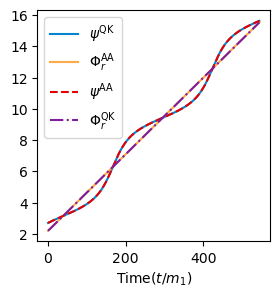

In [16]:
plt.figure(figsize=(3, 3))

plt.plot(t[1:800], psi[1:800],color=plotColors[0],label='$\psi^{\\text{QK}}$')
plt.plot(t[1:800], Phi_r[1:800],color=plotColors[1],label='$\Phi_r^{\\text{AA}}$')
plt.plot(t[1:800], psi_from_AA[1:800],color=plotColors[3],label='$\psi^{\\text{AA}}$', linestyle='dashed')
plt.plot(t[1:800], Phi_r_from_QK[1:800],color=plotColors[4],label='$\Phi_r^{\\text{QK}}$', linestyle='dashdot')

plt.xlabel('$\\text{Time} (t/m_1)$')

plt.legend()
#plt.savefig("../figures/PhasesRadial.pdf",format="pdf",bbox_inches="tight")
plt.show()

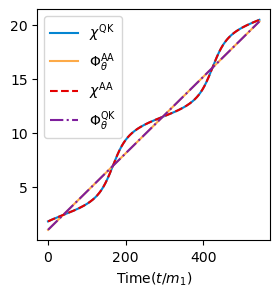

In [17]:
plt.figure(figsize=(3, 3))

plt.plot(t[1:800], chi[1:800],color=plotColors[0],label='$\chi^{\\text{QK}}$')
plt.plot(t[1:800], Phi_theta[1:800],color=plotColors[1],label='$\Phi_\\theta^{\\text{AA}}$')
plt.plot(t[1:800], chi_from_AA[1:800],color=plotColors[3],label='$\chi^{\\text{AA}}$', linestyle='dashed')
plt.plot(t[1:800], Phi_theta_from_QK[1:800],color=plotColors[4],label='$\Phi_\\theta^{\\text{QK}}$', linestyle='dashdot')

plt.xlabel('$\\text{Time} (t/m_1)$')

plt.legend()
#plt.savefig("../figures/PhasesPolar.pdf",format="pdf",bbox_inches="tight")

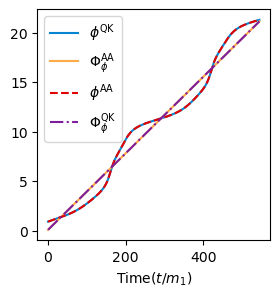

In [18]:
plt.figure(figsize=(3, 3))

plt.plot(t[1:800], phi[1:800],color=plotColors[0],label='$\phi^{\\text{QK}}$')
plt.plot(t[1:800], Phi_phi[1:800],color=plotColors[1],label='$\Phi_\phi^{\\text{AA}}$')
plt.plot(t[1:800], phi_from_AA[1:800],color=plotColors[3],label='$\phi^{\\text{AA}}$', linestyle='dashed')
plt.plot(t[1:800], Phi_phi_from_QK[1:800],color=plotColors[4],label='$\Phi_\phi^{\\text{QK}}$', linestyle='dashdot')

plt.xlabel('$\\text{Time} (t/m_1)$')

plt.legend()
#plt.savefig("../figures/PhasesAzimuthal.pdf",format="pdf",bbox_inches="tight")

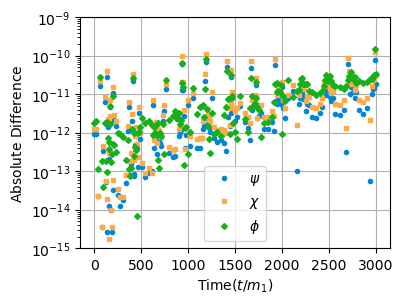

In [20]:
# Absolute Error from 
plt.figure(figsize=(4, 3))

inc = 20
psiError = np.zeros(int(len(t)/inc) + 1)
chiError = np.zeros(int(len(t)/inc) + 1)
phiError = np.zeros(int(len(t)/inc) + 1)
tInc = np.zeros(int(len(t)/inc)+ 1)


for i in range(0,len(t),inc):
    psiError[int(i/inc)] = abs(psi[i] - psi_from_AA[i])
    chiError[int(i/inc)] = abs(chi[i] - chi_from_AA[i])
    phiError[int(i/inc)] = abs(phi[i] - phi_from_AA[i])
    tInc[int(i/inc)] = t[i]

# Plot x(t)
plt.yscale('log')
plt.plot(tInc, psiError,color=plotColors[0],marker= 'o', linestyle= 'none',label='$\psi$', markersize='3')
plt.plot(tInc, chiError, color=plotColors[1],marker= 's', linestyle= 'none',label='$\chi$',markersize='3')
plt.plot(tInc, phiError, color=plotColors[2],marker= 'D', linestyle= 'none', label='$\phi$',markersize='3')
# Plot y(t)



#plt.plot(t, psi_from_AA, label='$\psi (t)$ from Action Angles', color='red',linestyle='dashed')

# Labels and title
plt.xlabel('$\\text{Time} (t/m_1)$')
plt.ylabel('$\\text{Absolute Difference}$')
plt.legend()

ax = plt.gca()
ax.set_ylim([1e-15,1e-9])
# Show the plot
plt.grid(True)


#plt.savefig("../figures/QuasiKeplerianError.pdf",format="pdf",bbox_inches="tight")

plt.show()

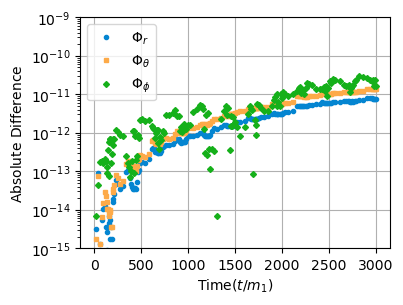

In [22]:
# Absolute Error Plots
plt.figure(figsize=(4, 3))

inc = 20
Phi_r_Error = np.zeros(int(len(t)/inc) + 1)
Phi_theta_Error = np.zeros(int(len(t)/inc) + 1)
Phi_phi_Error = np.zeros(int(len(t)/inc) + 1)
tInc = np.zeros(int(len(t)/inc)+ 1)


for i in range(0,len(t),inc):
    Phi_r_Error[int(i/inc)] = abs(Phi_r[i] - Phi_r_from_QK[i])
    Phi_theta_Error[int(i/inc)] = abs(Phi_theta[i] - Phi_theta_from_QK[i])
    Phi_phi_Error[int(i/inc)] = abs(Phi_phi[i] - Phi_phi_from_QK[i])
    tInc[int(i/inc)] = t[i]

# Plot x(t)
plt.yscale('log')
plt.plot(tInc, Phi_r_Error,color = plotColors[0],marker= 'o', linestyle= 'none',label='$\Phi_r$', markersize='3')
plt.plot(tInc, Phi_theta_Error, color=plotColors[1],marker= 's', linestyle= 'none',label='$\Phi_{\\theta}$',markersize='3')
plt.plot(tInc, Phi_phi_Error, color=plotColors[2],marker= 'D', linestyle= 'none', label='$\Phi_\phi$',markersize='3')
# Plot y(t)



#plt.plot(t, psi_from_AA, label='$\psi (t)$ from Action Angles', color='red',linestyle='dashed')

# Labels and title
plt.xlabel('$\\text{Time} (t/m_1)$')
plt.ylabel('$\\text{Absolute Difference}$')
plt.legend()

ax = plt.gca()
ax.set_ylim([1e-15,1e-9])
# Show the plot
plt.grid(True)

#plt.savefig("../figures/ActionAngleError.pdf",format="pdf",bbox_inches="tight")

plt.show()

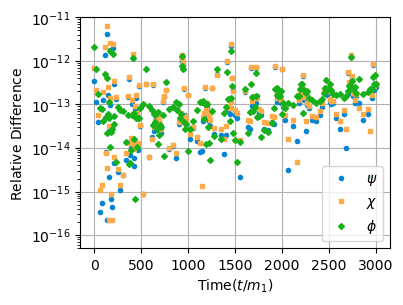

In [25]:
# Relative Error from 
plt.figure(figsize=(4, 3))

inc = 20
psiError = np.zeros(int(len(t)/inc) + 1)
chiError = np.zeros(int(len(t)/inc) + 1)
phiError = np.zeros(int(len(t)/inc) + 1)
tInc = np.zeros(int(len(t)/inc)+ 1)


for i in range(1,len(t),inc):
    psiError[int(i/inc)] = abs(1 - psi[i]/ psi_from_AA[i])
    chiError[int(i/inc)] = abs(1- chi[i]/ chi_from_AA[i])
    phiError[int(i/inc)] = abs(1- phi[i]/ phi_from_AA[i])
    tInc[int(i/inc)] = t[i]

# Plot x(t)
plt.yscale('log')
plt.plot(tInc, psiError,color=plotColors[0],marker= 'o', linestyle= 'none',label='$\psi$', markersize='3')
plt.plot(tInc, chiError, color=plotColors[1],marker= 's', linestyle= 'none',label='$\chi$',markersize='3')
plt.plot(tInc, phiError, color=plotColors[2],marker= 'D', linestyle= 'none', label='$\phi$',markersize='3')
# Plot y(t)



#plt.plot(t, psi_from_AA, label='$\psi (t)$ from Action Angles', color='red',linestyle='dashed')

# Labels and title
plt.xlabel('$\\text{Time} (t/m_1)$')
plt.ylabel('$\\text{Relative Difference}$')
plt.legend()

ax = plt.gca()
ax.set_ylim([5e-17,1e-11])
# Show the plot
plt.grid(True)


plt.savefig("../figures/QuasiKeplerianRelativeError.pdf",format="pdf",bbox_inches="tight")

plt.show()

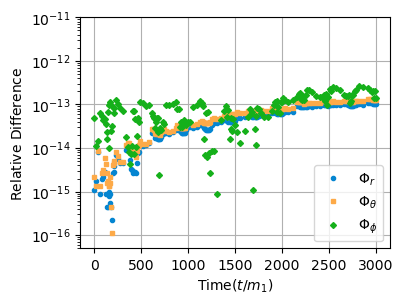

In [26]:
# Absolute Error Plots
plt.figure(figsize=(4, 3))

inc = 20
Phi_r_Error = np.zeros(int(len(t)/inc) + 1)
Phi_theta_Error = np.zeros(int(len(t)/inc) + 1)
Phi_phi_Error = np.zeros(int(len(t)/inc) + 1)
tInc = np.zeros(int(len(t)/inc)+ 1)


for i in range(1,len(t),inc):
    Phi_r_Error[int(i/inc)] = abs(1 - Phi_r[i] / Phi_r_from_QK[i])
    Phi_theta_Error[int(i/inc)] = abs(1 - Phi_theta[i] / Phi_theta_from_QK[i])
    Phi_phi_Error[int(i/inc)] = abs(1 - Phi_phi[i] / Phi_phi_from_QK[i])
    tInc[int(i/inc)] = t[i]

# Plot x(t)
plt.yscale('log')
plt.plot(tInc, Phi_r_Error,color = plotColors[0],marker= 'o', linestyle= 'none',label='$\Phi_r$', markersize='3')
plt.plot(tInc, Phi_theta_Error, color=plotColors[1],marker= 's', linestyle= 'none',label='$\Phi_{\\theta}$',markersize='3')
plt.plot(tInc, Phi_phi_Error, color=plotColors[2],marker= 'D', linestyle= 'none', label='$\Phi_\phi$',markersize='3')
# Plot y(t)



#plt.plot(t, psi_from_AA, label='$\psi (t)$ from Action Angles', color='red',linestyle='dashed')

# Labels and title
plt.xlabel('$\\text{Time} (t/m_1)$')
plt.ylabel('$\\text{Relative Difference}$')
plt.legend()

ax = plt.gca()
ax.set_ylim([5e-17,1e-11])
# Show the plot
plt.grid(True)

plt.savefig("../figures/ActionAngleRelativeError.pdf",format="pdf",bbox_inches="tight")

plt.show()

So we see that the error this last plot is in line with the relative tolarance of the ODE solver of $10^{-13}$

In [27]:
def Radial_Coordinate(p,e,psi):
    return p/(1 + e * np.cos(psi))

def Polar_Coordinate(x,chi):
    return np.arccos(np.sqrt(1 - x * x) * np.cos(chi))

In [28]:
r = Radial_Coordinate(p,e,psi)
theta = Polar_Coordinate(x,chi)

x_coord = r * np.sin(theta) * np.cos(phi)
y_coord = r * np.sin(theta) * np.sin(phi)
z_coord = r * np.cos(theta)

In [29]:
r_from_AA = Radial_Coordinate(p,e,psi_from_AA)
theta_from_AA = Polar_Coordinate(x,chi_from_AA)

x_coord_from_AA = r_from_AA * np.sin(theta_from_AA) * np.cos(phi_from_AA)
y_coord_from_AA = r_from_AA * np.sin(theta_from_AA) * np.sin(phi_from_AA)
z_coord_from_AA = r_from_AA * np.cos(theta_from_AA)

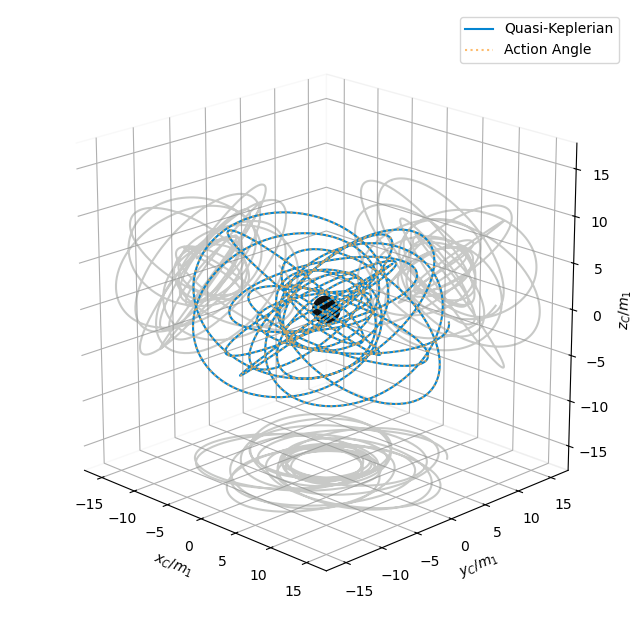

In [30]:

### First, let's create a black hole
# Define the radius of the BH
rBH = 1 + np.sqrt(1 - a*a)

# Create a mesh grid for the spherical coordinates
thetaBH = np.linspace(0,  np.pi, 100)
phiBH = np.linspace(0, 2 * np.pi, 100)
thetaBH, phiBH = np.meshgrid(thetaBH, phiBH)

# Parametric equations for the BH
xBH = rBH * np.sin(thetaBH) * np.cos(phiBH)
yBH = rBH * np.sin(thetaBH) * np.sin(phiBH)
zBH = rBH * np.cos(thetaBH)



# Create a new figure
fig = plt.figure(figsize=(8,8))

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the parametric BH
ax.plot_surface(xBH, yBH, zBH, color='black', edgecolor='none',zorder=3)

# Plot the trajectories
ax.plot(x_coord, y_coord, z_coord, label='Quasi-Keplerian', color=plotColors[0],alpha=1,zorder=3)
ax.plot(x_coord_from_AA, y_coord_from_AA, z_coord_from_AA, label='Action Angle', color=plotColors[1], linestyle='dotted',alpha=0.8,zorder=3)

pltMin = -p/(1 - e)-3
pltMax = p/(1 - e)+3

#ax.plot(x_coord, y_coord, np.full(len(t),pltMin), color=plotColors[5], zorder=5, alpha=0.5)
#ax.plot(x_coord, np.full(len(t),pltMin), z_coord, color=plotColors[5], zorder=4, alpha=0.5)
#ax.plot(np.full(len(t),pltMax), y_coord, z_coord, color=plotColors[5], zorder=3, alpha=0.5)

ax.plot(x_coord, y_coord,zs = pltMin, zdir='z', color=plotColors[5],alpha=0.5)
ax.plot(x_coord, z_coord,zs = pltMax, zdir='y', color=plotColors[5],alpha=0.5)
ax.plot(y_coord, z_coord,zs = pltMin, zdir='x', color=plotColors[5],alpha=0.5)
#ax.plot(x_coord, y_coord, z_coord, zdir='z')

# Add labels
ax.set_xlabel('$x_C/m_1$')
ax.set_ylabel('$y_C/m_1$')
ax.set_zlabel('$z_C/m_1$')
#ax.set_title('Kerr Geodesic: $(a,p,e,x) = (0.9,10,0.3,0.8)$')



ax.set_xlim([pltMin, pltMax])
ax.set_ylim([pltMin, pltMax])
ax.set_zlim([pltMin, pltMax])

ax.view_init(elev = 20, azim = -45)

ax.set_box_aspect([1, 1, 1], zoom=0.95)  # Equal aspect ratio for all axes
# Show the legend
ax.legend()
ax.grid()
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Save Plot
plt.savefig("../figures/TrajectoryVisualization.pdf",format="pdf", bbox_inches="tight" )

# Display the plot
plt.show()


## Timing Analysis

### Code to generate random parameters

In [39]:
from numpy.random import seed, uniform, randint

def gen_parameters(NEVAL, seed_in=314159):


    a_range = [0, 0.999]
    p_range = [15,50]
    e_range = [0.0, 0.9]
    x_range = [-1.0, 1.0] 
    psi_range = [0, 2* np.pi]
    chi_range = [0, 2* np.pi]
    phi_range = [0, 2* np.pi]
     

    _base_params = [
        0.9, # a0
        20, # p0
        0.3, # e0
        0.5,  # x0
        1.2, # psi0
        0.5, # chi0
        5, # phi0
    ]


    seed(seed_in)
    a_seed, p_seed, e_seed, x_seed, psi_seed, chi_seed, phi_seed = randint(1E3, 1E5, size=7)

    seed(a_seed)
    a_list = uniform(low=a_range[0], high=a_range[1], size=NEVAL)
    seed(p_seed)
    p_list = uniform(low=p_range[0], high=p_range[1], size=NEVAL)
    seed(e_seed)
    e_list = uniform(low=e_range[0], high=e_range[1], size=NEVAL)
    seed(x_seed)
    x_list = uniform(low=x_range[0], high=x_range[1], size=NEVAL)
    seed(psi_seed)
    psi_list = uniform(low=psi_range[0], high=psi_range[1], size=NEVAL)
    seed(chi_seed)
    chi_list = uniform(low=chi_range[0], high=chi_range[1], size=NEVAL)
    seed(phi_seed)
    phi_list = uniform(low=phi_range[0], high=phi_range[1], size=NEVAL)

    output_params_list = []
    failed_params_list = []

    for i, (a, p, e, x, psi, chi, phi) in enumerate(zip(
        a_list,
        p_list,
        e_list,
        x_list,
        psi_list,
        chi_list,
        phi_list
    )):

        try:
            # print(f"{i+1}:\t{M}, {mu}, {a}, {e}")
            updated_params = _base_params.copy()

            updated_params[0] = a
            updated_params[1] = p
            updated_params[2] = e
            updated_params[3] = x
            updated_params[4] = psi
            updated_params[5] = chi
            updated_params[6] = phi

            output_params_list.append(
                updated_params.copy()
            )
        except ValueError:
            failed_params_list.append([a, p, e, x, psi, chi, phi])

    return output_params_list

In [ ]:
params = gen_parameters(NEVAL=10000, seed_in=314159)
params

[0.7496324124102276,
 21.22220766541497,
 0.3380235043013564,
 0.8605988513906888,
 2.425070416977483,
 2.2419964117104034,
 3.9381646157721186]

In [ ]:
# Save the parameters to a file to use in MMA for consistency
params = np.loadtxt("../data/QuasiKeplerianParameters.txt", skiprows=1, delimiter=',')

In [81]:
[a,p,e,x,psi0,chi0,phi0]  = params[0]
time = perf_counter()
(Phi_r,Phi_theta,Phi_phi) = kac.pyDarwinPhasesToBoyerLindquistPhases(a,p,e,x,psi0,chi0,phi0)
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)
(Phi_r,Phi_theta,Phi_phi)

Time taken: 0.081 ms


(1.9192349095620669, 1.660348602805168, 3.416311412001084)

In [82]:
time = perf_counter()
(psi2,chi2,phi2) = kac.pyBoyerLindquistPhasesToDarwinPhases(a,p,e,x,Phi_r,Phi_theta,Phi_phi)
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)
(psi2,chi2,phi2)

Time taken: 0.261 ms


(2.42507, 2.241995999999998, 3.93816499999997)

In [83]:
transformation_timings = []
inverse_timings = [] 

for i in range(len(params)):
    [a,p,e,x,psi0,chi0,phi0]  = params[i]
    time = perf_counter()
    (Phi_r,Phi_theta,Phi_phi) = kac.pyDarwinPhasesToBoyerLindquistPhases(a,p,e,x,psi0,chi0,phi0)
    total_time = (perf_counter() - time)
    transformation_timings.append(total_time)

    time = perf_counter()
    (psi2,chi2,phi2) = kac.pyBoyerLindquistPhasesToDarwinPhases(a,p,e,x,Phi_r,Phi_theta,Phi_phi)
    total_time = (perf_counter() - time)
    inverse_timings.append(total_time)


In [91]:
np.savetxt("../data/QuasiKeplerianParameters.txt", params, fmt='%.6f', delimiter=',', header='a,p,e,x,psi,chi,phi', comments='')

In [71]:
MMAtimings = np.loadtxt("../data/MMAtimings.txt")
MMADubPrectimings = np.loadtxt("../data/MMAtimingsDoublePrec.txt")

In [85]:
import seaborn as sns
colorblind_palette = sns.color_palette('colorblind')
import matplotlib.colors as mcolors

colorblind_hex = [mcolors.to_hex(color) for color in colorblind_palette]

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]

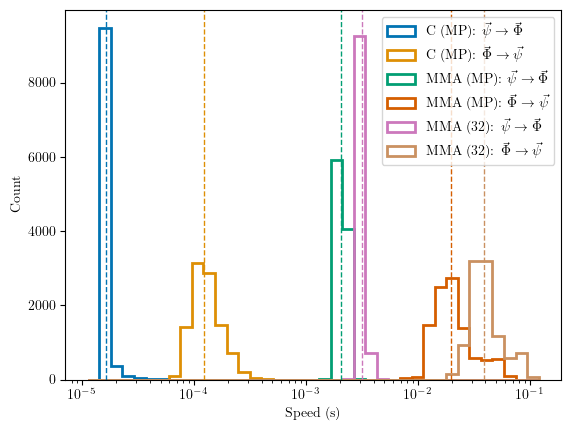

In [99]:
# Plotting the histogram of dephasings

_min, _max = min(transformation_timings), max(MMADubPrectimings[:,1])
lb = np.logspace(np.log10(_min)-0.1, np.log10(_max), 40)


# bins1 = np.arange(-5,-3.01,0.1)
#bins1 = np.arange(0, 0.8, 0.01)


plt.hist(transformation_timings, bins=lb, histtype='stepfilled', facecolor='none', edgecolor=colorblind_hex[0], linewidth=2, label=r'C (MP): $\vec{\psi} \rightarrow \vec{\Phi}$')
plt.hist(inverse_timings, bins=lb, histtype='stepfilled',facecolor='none', edgecolor=colorblind_hex[1], linewidth=2, label=r'C (MP): $ \vec{\Phi} \rightarrow \vec{\psi}$')
plt.hist(MMAtimings[:,0], bins=lb, histtype='stepfilled', facecolor='none', edgecolor=colorblind_hex[2], linewidth=2, label=r'MMA (MP): $\vec{\psi} \rightarrow \vec{\Phi}$')
plt.hist(MMAtimings[:,1], bins=lb, histtype='stepfilled',facecolor='none', edgecolor=colorblind_hex[3], linewidth=2, label=r'MMA (MP): $ \vec{\Phi} \rightarrow \vec{\psi}$')
plt.hist(MMADubPrectimings[:,0], bins=lb, histtype='stepfilled', facecolor='none', edgecolor=colorblind_hex[4], linewidth=2, label=r'MMA (32): $\vec{\psi} \rightarrow \vec{\Phi}$')
plt.hist(MMADubPrectimings[:,1], bins=lb, histtype='stepfilled',facecolor='none', edgecolor=colorblind_hex[5], linewidth=2, label=r'MMA (32): $ \vec{\Phi} \rightarrow \vec{\psi}$')

median1 = np.median(transformation_timings)
median2 = np.median(inverse_timings)
median3 = np.median(MMAtimings[:,0])
median4 = np.median(MMAtimings[:,1])
median5 = np.median(MMADubPrectimings[:,0])
median6 = np.median(MMADubPrectimings[:,1])

# Add vertical lines at the medians
plt.axvline(median1, color=colorblind_hex[0], linestyle='dashed', linewidth=1)
plt.axvline(median2, color=colorblind_hex[1], linestyle='dashed', linewidth=1)
plt.axvline(median3, color=colorblind_hex[2], linestyle='dashed', linewidth=1)
plt.axvline(median4, color=colorblind_hex[3], linestyle='dashed', linewidth=1)
plt.axvline(median5, color=colorblind_hex[4], linestyle='dashed', linewidth=1)
plt.axvline(median6, color=colorblind_hex[5], linestyle='dashed', linewidth=1)

plt.xscale('log')
plt.xlabel("Speed (s)")
plt.ylabel("Count")
plt.legend()
plt.savefig("../figures/TimingHistograms.pdf")
plt.show()


In [96]:
median1, median2,median3, median4, median5, median6

(1.633300053072162e-05,
 0.00012291650000406662,
 0.002047,
 0.0197995,
 0.00314,
 0.0386245)